# ****Question-1****

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, input_shape, num_classes, num_filters, filter_size, activation_conv, activation_dense, num_neurons_dense):
        super(CNN, self).__init__()
        self.conv_layers = self._create_conv_layers(input_shape[0], num_filters, filter_size, activation_conv)
        self.fc_layers = nn.Sequential(
            nn.Linear(256 * 7 * 7, num_neurons_dense),
            activation_dense,
            nn.Linear(num_neurons_dense, num_classes)
        )

    def _create_conv_layers(self, input_channels, num_filters, filter_size, activation_conv):
        layers = []
        in_channels = input_channels
        for _ in range(5):  # Reduced to 5 convolutional layers
            layers += [
                nn.Conv2d(in_channels, num_filters, filter_size, padding=1),
                activation_conv,
                nn.MaxPool2d(kernel_size=2, stride=2)
            ]
            in_channels = num_filters
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

# Example parameters
input_shape = (3, 224, 224)  # Example shape compatible with iNaturalist dataset
num_classes = 10  # Number of classes in iNaturalist dataset
num_filters = 32  # Number of filters in convolutional layers
filter_size = 3  # Size of filters

# Define activation functions for convolutional and dense layers
activation_conv = nn.ReLU(inplace=True)  # Activation function for convolutional layers
activation_dense = nn.ReLU(inplace=True)  # Activation function for dense layer

num_neurons_dense = 1024  # Number of neurons in dense layer

# Create the model
model = CNN(input_shape, num_classes, num_filters, filter_size, activation_conv, activation_dense, num_neurons_dense)

# Display model summary
print(model)




CNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequenti

# **Question-2**

In [2]:

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset
import torch.nn.functional as F
from PIL import Image
import os
import random
from collections import defaultdict  # Import defaultdict
import numpy as np
from torch.utils.data import random_split
from torch.utils.data import Subset
import matplotlib.pyplot as plt
import wandb
from tqdm import tqdm

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:

# Define CNN architecture
class CNN(nn.Module):
    def __init__(self, input_channels, num_classes,num_filters,filter_organization,filter_size,activation,batch_normalization,dropout_value,num_nuerons):
        super(CNN, self).__init__()

        self.conv_layers = nn.ModuleList()  # ModuleList to store the convolutional layers

        # Define the convolutional layers dynamically using a loop
        padding=1
        if activation == 'relu':
            act=nn.ReLU()
          
        elif activation == 'gelu':
            act=nn.GELU()
      
        elif activation == 'silu':
            act=nn.SiLU()
   
        elif activation == 'mish':
            act=Mish()
        
        in_channels = input_channels
        
        out_size = 224
        for i in range(5):
            self.conv_layers.append(nn.Conv2d(in_channels, num_filters, kernel_size=filter_size, padding=padding))
            if batch_normalization:
                self.conv_layers.append(nn.BatchNorm2d(num_filters))
          
            self.conv_layers.append(act)  

            self.conv_layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            
            if(dropout_value > 0):
                self.conv_layers.append(nn.Dropout(dropout_value))
                
            
            in_channels = num_filters
            
            
            pool_kernel_size=2
            pool_stride=2
            
            # Update num_filters based on filter_organization
            if filter_organization == 'double':
                num_filters = int(num_filters * 2)
            elif filter_organization == 'halve':
                num_filters = int(num_filters / 2)
            elif filter_organization == 'same':
                num_filters=num_filters
            
            
                    
            # Update out_size based on pooling parameters
            out_size = ((out_size + 2 * padding - pool_kernel_size) // pool_stride )+ 1
                
                
        
                
        
        

        self.fc1 = nn.Linear(in_channels * (out_size-1) * (out_size-1), num_nuerons)
        self.fc2 = nn.Linear(num_nuerons, num_classes)

    def forward(self, x):
        for layer in self.conv_layers:
            x = layer(x)

        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # Exclude batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    
    
class Mish(nn.Module):
    def forward(self, x):
        return x * torch.tanh(F.softplus(x))





In [4]:
def data_loader(train_data_folder,batch_size,data_augmentation):
    
    
    without_augmentation_transform =  transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
    # Load the original training dataset
    train_dataset = datasets.ImageFolder(root=train_data_folder, transform=without_augmentation_transform)

    # Shuffle the dataset
    indices = list(range(len(train_dataset)))
    np.random.shuffle(indices)
    
    # Calculate the size of the validation set (20% of the training data)
    val_size = int(0.2 * len(train_dataset))
    
    # Calculate the number of samples per class for validation
    num_classes = len(train_dataset.classes)
    val_size_per_class = val_size // num_classes
    
    # Initialize lists to store indices for training and validation
    train_indices = []
    val_indices = []
    
    # Iterate through each class to select validation samples
    for class_idx in range(num_classes):
        class_indices = [i for i in indices if train_dataset.targets[i] == class_idx]
        val_indices.extend(class_indices[:val_size_per_class])
        train_indices.extend(class_indices[val_size_per_class:])
    


    if data_augmentation:

        # Define data augmentation transforms for training data
        train_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.Resize((224, 224)),
            transforms.RandomRotation(10),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        
        # Create PyTorch data loaders for the initial dataset
        train_loader = DataLoader(Subset(train_dataset, train_indices), batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(Subset(train_dataset, val_indices), batch_size=batch_size, shuffle=True)
        
        
        transformed_dataset = datasets.ImageFolder(root=train_data_folder, transform=train_transform)
        transformed_loader = DataLoader(Subset(transformed_dataset, train_indices), batch_size=batch_size, shuffle=True)
        




  
        


        # Concatenate transformed datasets
        combined_train_dataset = ConcatDataset([train_loader.dataset,transformed_loader.dataset ])  # You can repeat train_dataset_transformed multiple times as needed
        
        # Define data loaders for combined datasets
        train_loader = DataLoader(dataset=combined_train_dataset, batch_size=batch_size, shuffle=True)
    

    else:
        # Create PyTorch data loaders for the initial dataset
        train_loader = DataLoader(Subset(train_dataset, train_indices), batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(Subset(train_dataset, val_indices), batch_size=batch_size, shuffle=True)


    
    return train_loader , val_loader

In [5]:

# Define training function
def train(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total
    return train_loss, train_accuracy

# Define testing function
def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_loss = running_loss / len(val_loader)
    val_accuracy = correct / total
    return val_loss, val_accuracy


In [6]:
# def arguments(num_filters,batch_size,activation,filter_organization,batch_normalization,data_augmentation,dropout_value,num_nuerons,lr,num_epochs):
    


#     # Set random seed
#     torch.manual_seed(42)
    
    
#     # Set device
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#     train_data_folder='/kaggle/input/inaturalist/inaturalist_12K/train'

#     train_dataset = datasets.ImageFolder(root=train_data_folder)
    


    

#     # Model parameters
#     input_channels = 3
#     num_classes = len(train_dataset.classes)







#     filter_size=3
    
#     if(batch_normalization == "Yes"):
#         batch_normalization_val=True
#     elif(batch_normalization == "No"):
#         batch_normalization_val=False
        
    
    
    
    
#     if(data_augmentation == "Yes"):
#         data_augmentation_val=True
#     elif(data_augmentation == "No"):
#         data_augmentation_val=False
    
#     train_loader , val_loader=data_loader(train_data_folder,batch_size,data_augmentation_val)

#     # Create model instance
#     model = CNN(input_channels, num_classes, num_filters,filter_organization,filter_size,activation,batch_normalization_val,dropout_value,num_nuerons).to(device)

#     # Loss function and optimizer
#     criterion = nn.CrossEntropyLoss()
#     optimizer = optim.Adam(model.parameters(), lr)



#     # Training loop
  
#     for epoch in range(num_epochs):
#         # Initialize tqdm progress bars for training and validation
#         train_progress = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Training', leave=False)

#         # Training loop
#         train_loss, train_accuracy = train(model, train_loader, optimizer, criterion, device)

#         # Close the tqdm progress bar for training
#         train_progress.close()

#         # Initialize tqdm progress bar for validation
#         val_progress = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Validation', leave=False)

#         # Validation loop
#         val_loss, val_accuracy = validate(model, val_loader, criterion, device)

#         # Close the tqdm progress bar for validation
#         val_progress.close()

#         # Log to Weights & Biases
#         wandb.log({
#             "Epoch": epoch + 1,
#             "Train_Accuracy": train_accuracy,
#             "Train_Loss": train_loss,
#             "Val_Accuracy": val_accuracy,
#             "Val_Loss": val_loss
#         })

#         # Print epoch results
#         print(f"Epoch {epoch+1}/{num_epochs},\n Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f},\n Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

In [7]:
wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [8]:
# # sweep_config = {
# #     'method': 'bayes',
# #     'name'  : 'Train Dataset Run - 2',
# #     'metric': {'goal': 'maximize', 'name': 'Val_Accuracy'},
# #     'parameters': {
# #         'num_filters': {'values': [32, 64, 128]},
# #         'activation': {'values': ['relu', 'gelu', 'silu', 'mish']},
# #         'filter_organization': {'values': ['same', 'double', 'halve']},
# #         'batch_normalization': {'values': ['Yes', 'No']},
# #         'dropout_value': {'values': [0.2, 0.3]},
# #         'learning_rate': {'values': [0.001, 0.0001]},
# #         'num_epochs': {'values': [5,10]},
# #         'dense_neurons': {'values': [128, 256, 512, 1024]},
# #         'batch_size': {'values': [32, 64]},
# #         'data_augmentation': {'values': ['Yes', 'No']}
# #     }
# # }
# sweep_config = {
#     'method': 'grid',
#     'name'  : 'Train Dataset Run - 2',
#     'metric': {'goal': 'maximize', 'name': 'Val_Accuracy'},
#     'parameters': {
#         'num_filters': {'values': [128]},
#         'activation': {'values': ['gelu', 'mish' ,'silu','relu']},
#         'filter_organization': {'values': [ 'double']},
#         'batch_normalization': {'values': ['Yes']},
#         'dropout_value': {'values': [ 0.2]},
#         'learning_rate': {'values': [0.001]},
#         'num_epochs': {'values': [10]},
#         'dense_neurons': {'values': [ 1024]},
#         'batch_size': {'values': [32]},
#         'data_augmentation': {'values': ['Yes']}
#     }
# }

# # sweep_config = {
# #     'method': 'random',
# #     'metric': {'goal': 'maximize', 'name': 'Val_Accuracy'},
# #     'parameters': {
# #         'num_filters': {'values': [32,64,128]},
# #         'activation': {'values': ['relu', 'gelu', 'silu', 'mish']},
# #         'filter_organization': {'values': ['same', 'double', 'halve']},
# #         'batch_normalization': {'values': ['Yes', 'No']},
# #         'dropout_value': {'values': [0.2,0.3]},
# #         'learning_rate': {'values': [0.001,0.0001]},
# #         'num_epochs': {'values': [5]},
# #         'dense_neurons': {'values': [128, 256,512]},
# #         'batch_size': {'values': [32,64]},
# #         'data_augmentation': {'values': ['Yes', 'No']}
# #     }
# # }






# # Create sweep
# sweep_id = wandb.sweep(sweep=sweep_config, project="DL_Assignment_2_CS23M046")



In [9]:
# def main():
    
#     # Initialize wandb
#     with wandb.init() as run:

#         config = wandb.config
        
#         run_name="activation_"+str(config.activation)+"_num_filters_"+str(config.num_filters)+"_dense_"+str(config.dense_neurons)+"_lr_"+str(config.learning_rate)
#         wandb.run.name=run_name
        
#         arguments(config.num_filters,config.batch_size,config.activation,config.filter_organization,config.batch_normalization,config.data_augmentation,config.dropout_value,config.dense_neurons,config.learning_rate,config.num_epochs)






# # Run sweep
# wandb.agent(sweep_id, function=main, count=4)

# wandb.finish()

# Question 4

In [10]:
# Define testing function
def test(model, test_loader, optimizer, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_loss = running_loss / len(test_loader)
    test_accuracy = correct / total
    return test_loss, test_accuracy



In [11]:


def plotgridimage(best_model, test_loader, classes):
    def imshow_grid(images, actual_labels, predicted_labels, title):
        fig, axs = plt.subplots(10, 3, figsize=(12, 40))


        for i, ax in enumerate(axs.flat):
            ax.imshow(np.transpose(images[i].numpy(), (1, 2, 0)))

            if actual_labels[i] == predicted_labels[i]:
                actual_color = 'green'
                predicted_color = 'green'
            else:
                actual_color = 'green'
                predicted_color = 'red'

            ax.set_title(f'Actual: {actual_labels[i]} \nPredicted: {predicted_labels[i]}', color=predicted_color, fontsize=15)
            ax.axis('off')

        plt.tight_layout(pad=3.0)
        plt.savefig("Sample_Predictions.png")
        wandb.log({title: [wandb.Image("Sample_Predictions.png")]})
        plt.show()
        plt.close()

    def evaluate_model(model, test_loader, classes):
        model.eval()
        class_images = {cls: [] for cls in classes}
        actual_labels = []
        predicted_labels = []
        images_shown = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)

                for i in range(len(labels)):
                    label = labels[i].item()
                    predicted_label = predicted[i].item()

                    class_name = classes[label]

                    if len(class_images[class_name]) < 3:
                        class_images[class_name].append(images[i].cpu())
                        actual_labels.append(classes[label])
                        predicted_labels.append(classes[predicted_label])
                        images_shown += 1

                    if images_shown >= 10 * 3:
                        images_to_show = torch.stack([img for sublist in class_images.values() for img in sublist[:3]])
                        actual_labels_to_show = actual_labels[:30]
                        predicted_labels_to_show = predicted_labels[:30]

                        imshow_grid(images_to_show, actual_labels_to_show, predicted_labels_to_show, 'Sample Predictions')
                        return

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    evaluate_model(best_model, test_loader, classes)


In [12]:
def arguments_2(num_filters,batch_size,activation,filter_organization,batch_normalization,data_augmentation,dropout_value,num_nuerons,lr,num_epochs):



    # Set random seed
    torch.manual_seed(42)


    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    without_augmentation_transform =  transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_data_folder='/kaggle/input/inaturalist/inaturalist_12K/train'


    train_dataset = datasets.ImageFolder(root=train_data_folder)

    

    # Model parameters
    input_channels = 3
    num_classes = len(train_dataset.classes)







    filter_size=3
    
    if(batch_normalization == "Yes"):
        batch_normalization_val=True
    elif(batch_normalization == "No"):
        batch_normalization_val=False
        
    
    
    
    
    if(data_augmentation == "Yes"):
        data_augmentation_val=True
    elif(data_augmentation == "No"):
        data_augmentation_val=False

#     input_channels=3
#     num_classes=10
#     num_filters=128
#     filter_organization='double'
#     filter_size=3
#     activation='gelu'
#     batch_normalization=True
#     dropout_value=0.3
#     num_nuerons=1024
#     data_augmentation_val =True
#     num_epochs=10
#     batch_size=32
#     lr = 0.0001

    train_loader , _ =data_loader(train_data_folder,batch_size,data_augmentation_val)


    test_data_folder='/kaggle/input/inaturalist/inaturalist_12K/val'

    test_dataset = datasets.ImageFolder(root=test_data_folder,transform=without_augmentation_transform)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)
    
    classes = test_dataset.classes

    # Create model instance
    best_model = CNN(input_channels, num_classes, num_filters,filter_organization,filter_size,activation,batch_normalization_val,dropout_value,num_nuerons).to(device)

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(best_model.parameters(), lr)

    # Wrap the entire training loop with tqdm to show progress
    for epoch in tqdm(range(num_epochs), desc='Training', leave=False):
        epoch_progress = tqdm(test_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False)
        train_loss, train_accuracy = train(best_model, train_loader, optimizer, criterion, device)
        test_loss, test_accuracy =test(best_model, test_loader, optimizer, criterion, device)

        # Log to Weights & Biases
        wandb.log({
            "Epoch": epoch + 1,
            "Train_Accuracy": train_accuracy,
            "Train_Loss": train_loss,
            "Test_Accuracy": test_accuracy,
            "Test_Loss": test_loss
        })

        # Print test loss and accuracy
        print(f'Test Loss: {test_loss}')
        print(f'Test Accuracy: {test_accuracy}')
        
    plotgridimage(best_model,test_loader,classes)
    
    


In [13]:
# # sweep_config = {
# #     'method': 'grid',
# #     'name'  : 'Test Dataset Run -2',
# #     'metric': {'goal': 'maximize', 'name': 'Val_Accuracy'},
# #     'parameters': {
# #         'num_filters': {'values': [128]},
# #         'activation': {'values': ['mish']},
# #         'filter_organization': {'values': ['double' ]},
# #         'batch_normalization': {'values': ['Yes']},
# #         'dropout_value': {'values': [0.3]},
# #         'learning_rate': {'values': [0.0001]},
# #         'num_epochs': {'values': [10]},
# #         'dense_neurons': {'values': [1024]},
# #         'batch_size': {'values': [32]},
# #         'data_augmentation': {'values': ['Yes']}
# #     }
# # }
sweep_config = {
    'method': 'grid',
    'name'  : 'Sample Prediction Plot Run ',
    'metric': {'goal': 'maximize', 'name': 'Val_Accuracy'},
    'parameters': {
        'num_filters': {'values': [128]},
        'activation': {'values': ['gelu']},
        'filter_organization': {'values': ['double']},
        'batch_normalization': {'values': ['Yes']},
        'dropout_value': {'values': [0.3]},
        'learning_rate': {'values': [0.0001]},
        'num_epochs': {'values': [10]},
        'dense_neurons': {'values': [1024]},
        'batch_size': {'values': [32]},
        'data_augmentation': {'values': ['Yes']}
    }
}






# Create sweep
sweep_id = wandb.sweep(sweep=sweep_config, project="DL_Assignment_2_CS23M046")

Create sweep with ID: flytd8au
Sweep URL: https://wandb.ai/cs23m046/DL_Assignment_2_CS23M046/sweeps/flytd8au


wandb: Agent Starting Run: 1e27rf0j with config:
wandb: 	activation: gelu
wandb: 	batch_normalization: Yes
wandb: 	batch_size: 32
wandb: 	data_augmentation: Yes
wandb: 	dense_neurons: 1024
wandb: 	dropout_value: 0.3
wandb: 	filter_organization: double
wandb: 	learning_rate: 0.0001
wandb: 	num_epochs: 10
wandb: 	num_filters: 128
wandb: Currently logged in as: cs23m046. Use `wandb login --relogin` to force relogin


Training:  10%|█         | 1/10 [10:08<1:31:15, 608.39s/it]

Test Loss: 2.1684141651032465
Test Accuracy: 0.231




Training:  20%|██        | 2/10 [18:08<1:11:02, 532.84s/it]

Test Loss: 2.0077435421565224
Test Accuracy: 0.309



Epoch 3/10:   0%|          | 0/63 [00:00<?, ?it/s]

Training:  30%|███       | 3/10 [26:10<59:26, 509.49s/it]  

Test Loss: 2.0737192252325634
Test Accuracy: 0.283




Training:  40%|████      | 4/10 [34:09<49:46, 497.80s/it]

Test Loss: 2.0640621525900706
Test Accuracy: 0.284



Epoch 5/10:   0%|          | 0/63 [00:00<?, ?it/s]

Training:  50%|█████     | 5/10 [42:10<40:58, 491.61s/it]

Test Loss: 1.8447557763447837
Test Accuracy: 0.363




Training:  60%|██████    | 6/10 [50:13<32:34, 488.54s/it]

Test Loss: 1.8444460365507338
Test Accuracy: 0.366



Epoch 7/10:   0%|          | 0/63 [00:00<?, ?it/s]

Training:  70%|███████   | 7/10 [58:16<24:20, 486.88s/it]

Test Loss: 1.8787955575519137
Test Accuracy: 0.371




Training:  80%|████████  | 8/10 [1:06:18<16:10, 485.42s/it]

Test Loss: 1.9016246133380466
Test Accuracy: 0.368



Epoch 9/10:   0%|          | 0/63 [00:00<?, ?it/s]

Training:  90%|█████████ | 9/10 [1:14:21<08:04, 484.42s/it]

Test Loss: 1.7766341633266873
Test Accuracy: 0.4155




Epoch 10/10:   0%|          | 0/63 [00:00<?, ?it/s]
                                                            

Test Loss: 1.8474138975143433
Test Accuracy: 0.4035


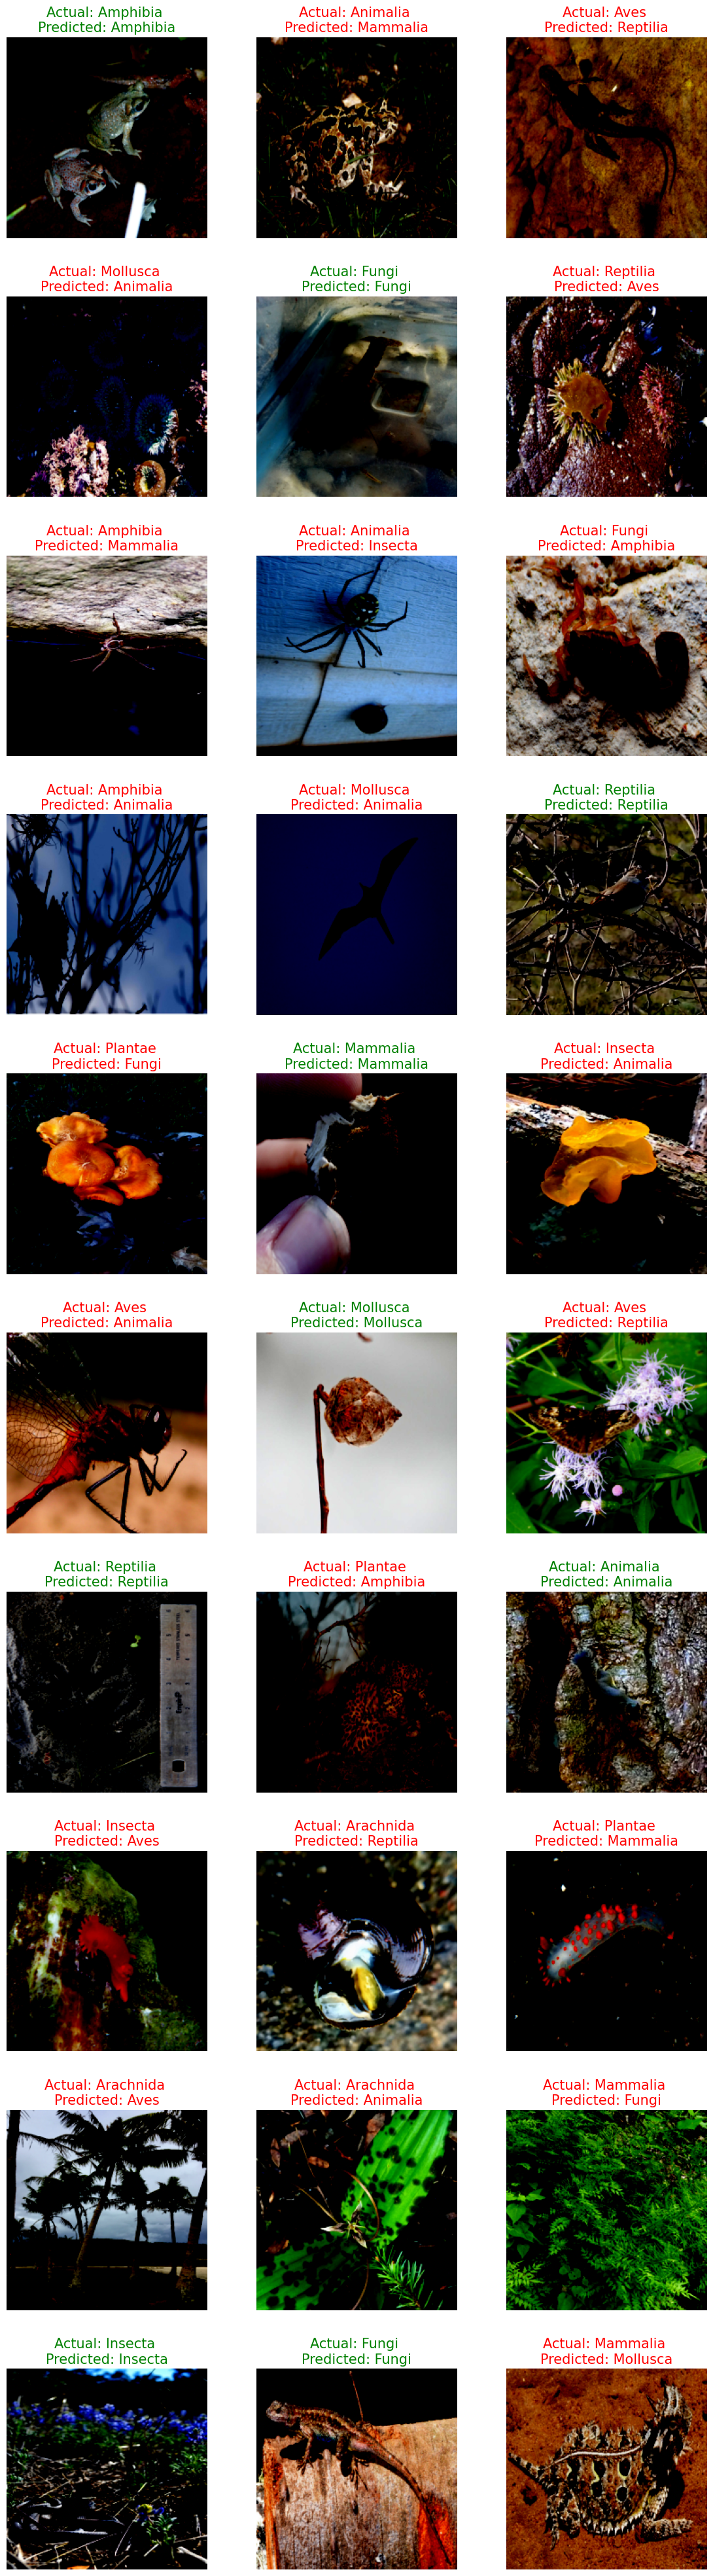

In [14]:
def main():
    
    # Initialize wandb
    with wandb.init() as run:

        config = wandb.config
        
        run_name="activation_"+str(config.activation)+"_num_filters_"+str(config.num_filters)+"_dense_"+str(config.dense_neurons)+"_lr_"+str(config.learning_rate)
        wandb.run.name=run_name
        
        temp_model=arguments_2(config.num_filters,config.batch_size,config.activation,config.filter_organization,config.batch_normalization,config.data_augmentation,config.dropout_value,config.dense_neurons,config.learning_rate,config.num_epochs)
        





# Run sweep
wandb.agent(sweep_id, function=main, count=1)

wandb.finish()